# Springboard Time Series - 'Cowboy Cigarettes' Case Study - Tier 3

## Brief

You're working in the US federal government as a data scientist in the Health and Environment department. You've been tasked with determining whether sales for the oldest and most powerful producers of cigarettes in the country are increasing or declining. 

**Cowboy Cigarettes (TM, *est.* 1890)** is the US's longest-running cigarette manufacturer. Like many cigarette companies, however, they haven't always been that public about their sales and marketing data. The available post-war historical data runs for only 11 years after they resumed production in 1949; stopping in 1960 before resuming again in 1970. Your job is to use the 1949-1960 data to predict whether the manufacturer's cigarette sales actually increased, decreased, or stayed the same. You need to make a probable reconstruction of the sales record of the manufacturer - predicting the future, from the perspective of the past - to contribute to a full report on US public health in relation to major cigarette companies. 

The results of your analysis will be used as part of a major report relating public health and local economics, and will be combined with other studies executed by your colleagues to provide important government advice.  

-------------------------------
As ever, this notebook is **tiered**, meaning you can elect that tier that is right for your confidence and skill level. There are 3 tiers, with tier 1 being the easiest and tier 3 being the hardest.  

**1. Sourcing and loading** 
- Load relevant libraries 
- Load the data
- Explore the data

 
**2. Cleaning, transforming and visualizing**
- Dropping unwanted columns
- Nomenclature
- Type conversions
- Making a predictor variable `y` 
- Getting summary statistics for `y`
- Plotting `y`
  
  
**3. Modelling** 
- Decomposition
    - Trend
    - Seasonality
    - Noise
- Testing for stationarity with KPSS
- Making the data stationary
- The ARIMA Model
    - Make a function to find the MSE of a single ARIMA model
    - Make a function to evaluate the different ARIMA models with different p, d, and q values
- Visualize the results
- Application: Forecasting

**4. Evaluating and concluding** 
- What is our conclusion?
- Next steps
    

## 0. Preliminaries 

Time series data is just any data displaying how a single variable changes over time. It comes as a collection of metrics typically taken at regular intervals. Common examples of time series data include weekly sales data and daily stock prices. You can also easily acquire time series data from [Google Trends](https://trends.google.com/trends/?geo=US), which shows you how popular certain search terms are, measured in number of Google searches. 

## 1. Sourcing and Loading

### 1a. Load relevant libraries 

In [184]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### 1b. Load the data
Call the variable `cigData`. 

In [185]:
cigData = pd.read_csv('CowboyCigsData.csv')

### 1b2. reverting back to original data

In [259]:
cigData=(cigData-1000000)*100000

### 1c. Explore the data
We now need to check whether the data conduces to a time series style analysis.

In [260]:
cigData.head()

,#CigSales
Month,
1949-01-01,11200000
1949-02-01,11800000
1949-03-01,13200000
1949-04-01,12900000
1949-05-01,12100000


Over a million cigarettes sold in the month of January 1949. This certainly is a popular cigarette brand. 

Check out the columns feature of the data. How many columns are there? 

In [261]:
cigData.shape

(144, 1)

Let's check out the data types of our columns.

In [262]:
cigData.dtypes

#CigSales    int64
dtype: object

Check whether there are any null values. 

In [263]:
cigData.isnull().any()

#CigSales    False
dtype: bool

## 2. Cleaning, transforming and visualizing

### 2a. Dropping unwanted columns
We need to cut that `Unnamed: 0` column. Delete it here.

In [ ]:
cigData.drop(columns='Unnamed: 0',inplace=True)

### 2b. Nomenclature

We can see that the `Time` column actually has the granularity of months. Change the name of that column to `Month`.

In [191]:
cigData.columns=['Month','#CigSales']

Call a head() to check this has worked. 

In [192]:
cigData.head()

,Month,#CigSales
0,1949-01,1000112
1,1949-02,1000118
2,1949-03,1000132
3,1949-04,1000129
4,1949-05,1000121


### 2c. Type conversions 

Now, do time series analysis on a Pandas dataframe is overkill, and is actually counter-productive. It's much more easy to carry out this type of analysis if we convert our data to a series first.

Notice that the `Month` field was an object. Let's type convert the `Month` column to a Python `datetime`, before making that the index.

In [ ]:
cigData['Month']=pd.to_datetime(cigData['Month'])

In [ ]:
cigData.set_index('Month',inplace=True)

In [268]:
cigData.head()

,#CigSales
Month,
1949-01-01,11200000
1949-02-01,11800000
1949-03-01,13200000
1949-04-01,12900000
1949-05-01,12100000


Perfect! 

### 2d. Making a predictor variable `y`

The data is now indexed by date, as time series data ought to be.

Since we want to predict the number of cigarette sales at Cowboy cigarettes, and `y` is typically used to signify a predictor variable, let's create a new variable called `y` and assign the indexed #Passenger column. 

In [269]:
y = cigData['#CigSales']

Check the type of our new variable. 

In [270]:
type(y)

pandas.core.series.Series

### 2e. Getting summary statistics for `y`

Get the summary statistics of our data here. 

In [271]:
y.describe()

count    1.440000e+02
mean     2.802986e+07
std      1.199663e+07
min      1.040000e+07
25%      1.800000e+07
50%      2.655000e+07
75%      3.605000e+07
max      6.220000e+07
Name: #CigSales, dtype: float64

Try visualizing the data. A simple `matplotlib` plot should do the trick.  

### 2f. Plotting `y`

<AxesSubplot:xlabel='Month'>

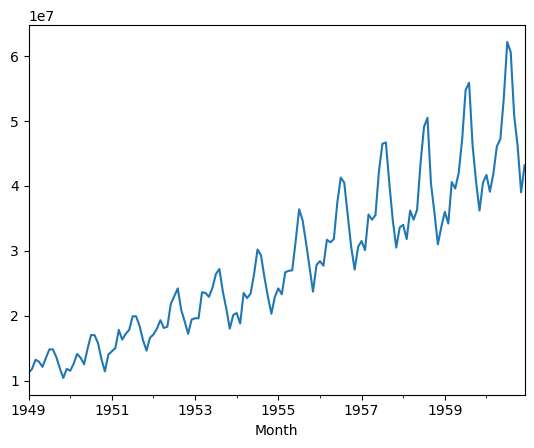

In [272]:
y.plot()

I observe 3 things: 
1. Upward trend that increases over time
2. the frequency is increasting
3. some seasonality to the dataset.

## 3. Modelling 
### 3a. Decomposition
What do you notice from the plot? Take at least `2` minutes to examine the plot, and write down everything you observe.  

All done?

We can see that, generally, there is a trend upwards in cigarette sales from at Cowboy Cigarettes. But there are also some striking - and perhaps unexpected - seasonal fluctuations. These seasonal fluctations come in a repeated pattern. Work out when these seasonal fluctuations are happening, and take 2 minutes to hypothesize on their cause here.

What does it mean to *decompose* time series data? It means breaking that data into 3 components: 

1. **Trend**: The overall direction that the data is travelling in (like upwards or downwards)
2. **Seasonality**: Cyclical patterns in the data 
3. **Noise**: The random variation in the data

We can treat these components differently, depending on the question and what's appropriate in the context. They can either be added together in an *additive* model, or multiplied together in a *multiplicative* model. 

Make a coffee, take `5` minutes and read [this article](https://medium.com/@sigmundojr/seasonality-in-python-additive-or-multiplicative-model-d4b9cf1f48a7) and think about whether our data would conduce to an additive or multiplicative model here. Write your conclusion down just here: 

-------------------------------

All done? Well, just on the basis of the plot above, it seems our Cowboy Cigarettes data is actually multiplicative. 

That's because, as time progresses, the general trend seems to be increasing *at a rate that's also increasing*. We also see that the seasonal fluctuations (the peaks and troughs) get bigger and bigger as time progresses.

Now on the other hand, if the data were simply additive, we could expect the general trend to increase at a *steadily*, and a constant speed; and also for seasonal ups and downs not to increase or decrease in extent over time.

Happily, we can use the `decompose()` function to quantify the component parts described above in our data.

In [273]:
import statsmodels.api as sm


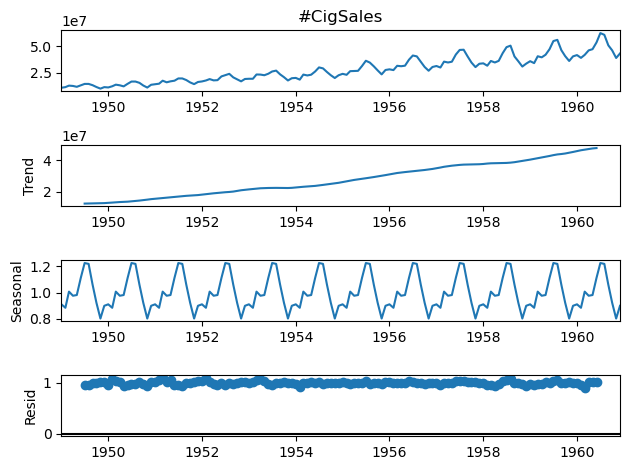

In [274]:
#multiplic
decomposition = sm.tsa.seasonal_decompose(y, model='multiplicative')
decomposition.plot()
plt.show()

### 3b. Testing for stationarity with KPSS and ADFULLER
As you know, when doing time series analysis we always have to check for stationarity. Imprecisely, a time series dataset is stationary just if its statistical features don't change over time. A little more precisely, a stationary time series dataset will have constant mean, variance, and covariance.

There are many ways to test for stationarity, but one of the most common is the KPSS test. The Null hypothesis of this test is that the time series data in question is stationary; hence, if the *p*-value is less than the significance level (typically 0.05, but we decide) then we reject the Null and infer that the data is not stationary.

In [275]:
#KPSS
from statsmodels.tsa.stattools import kpss
kpss(y)

(1.6513122354165233,
 0.01,
 8,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

Since our p-value is less than 0.05, we should reject the Null hypothesis and deduce the non-stationarity of our data. 

But our data need to be stationary! So we need to do some transforming.

In [276]:
#ADFULLER
from statsmodels.tsa.stattools import adfuller
adfuller(y)

(0.8153688792074538,
 0.991880243437663,
 13,
 130,
 {'1%': -3.4816817173418295,
  '5%': -2.8840418343195267,
  '10%': -2.578770059171598},
 3967.027700801338)

not < .05, therefore, not stationary

### 3c. Making the data stationary 
Let's recall what it looks like. 

<AxesSubplot:xlabel='Month'>

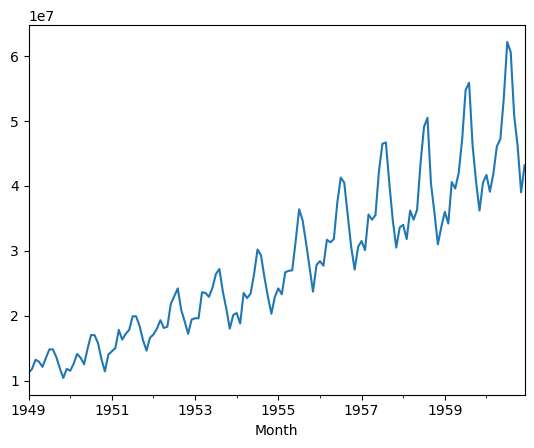

In [277]:
y.plot()

Since the amplitude is increasing over time (multiplicative seasonality), I'll log transform the data.

<AxesSubplot:xlabel='Month'>

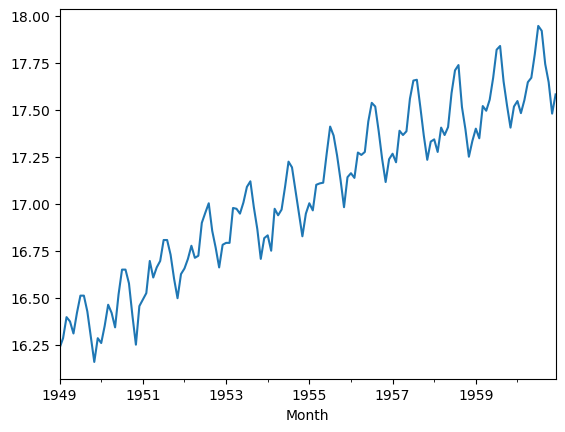

In [278]:
y_log=np.log(y)
y_log.plot()
#No difference can be seen but this is due to the dataset

Time to test again for stationarity

In [279]:
adfuller(y_log)

(-1.7170170891069931,
 0.42236677477037454,
 13,
 130,
 {'1%': -3.4816817173418295,
  '5%': -2.8840418343195267,
  '10%': -2.578770059171598},
 -445.3990312497208)

Still not stationary. Going to take the diff of the data

<AxesSubplot:xlabel='Month'>

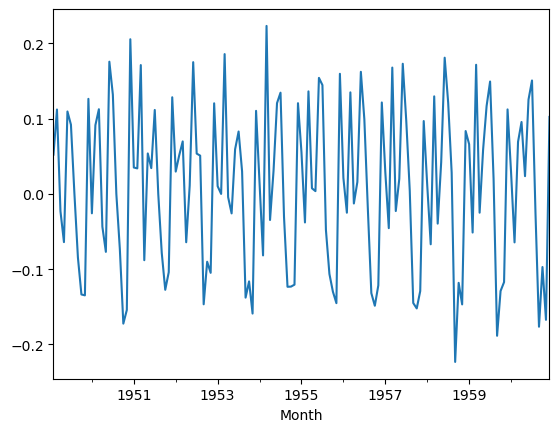

In [280]:
y_log_diff =y_log.diff().dropna()
y_log_diff.plot()

Perhaps we have some seasonality. Let's check with ACF plots

In [281]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

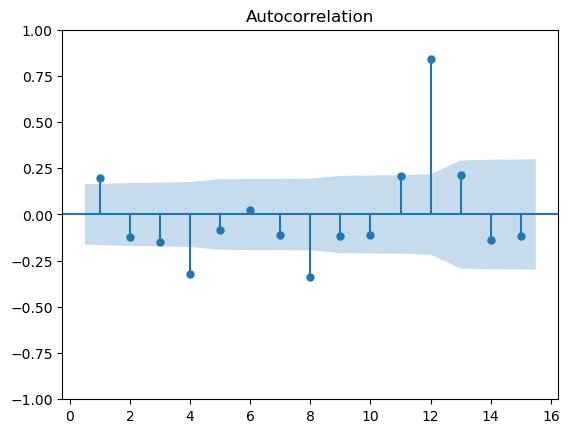

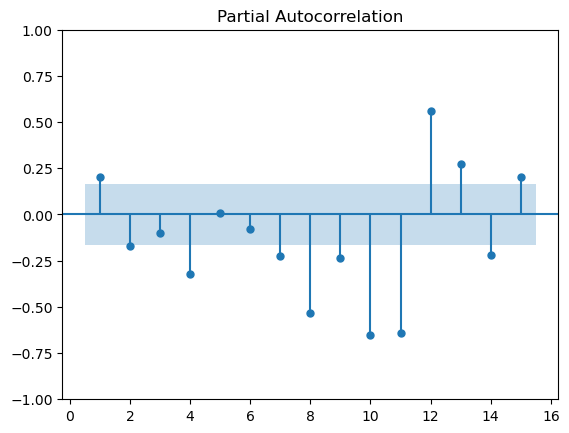

In [282]:
plot_acf(y_log_diff,lags=15, zero=False)
plot_pacf(y_log_diff,lags=15, zero=False)
plt.show()

Looks like annual seasonality

Text(0, 0.5, 'Log First Diff-Seasonality First Diff of #Cigs Sold')

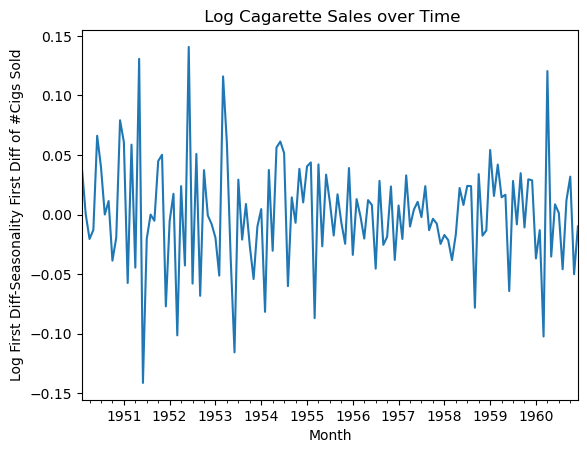

In [283]:
y_log_diff_season =y_log.diff().diff(12).dropna()
y_log_diff_season.plot()
plt.title(' Log Cagarette Sales over Time')
plt.ylabel('Log First Diff-Seasonality First Diff of #Cigs Sold')

Much better, lets test for seasonality

In [284]:
adfuller(y_log_diff_season)

(-4.443324941831146,
 0.00024859123113838127,
 12,
 118,
 {'1%': -3.4870216863700767,
  '5%': -2.8863625166643136,
  '10%': -2.580009026141913},
 -415.5597525461336)

BOOM!

## SARIMA Model

To get to this step we had to take the log, first diff and seasonality first diff with a time step of 12 months. AKA SARIMA(p,1,q)(P,1,Q,12)

In [285]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

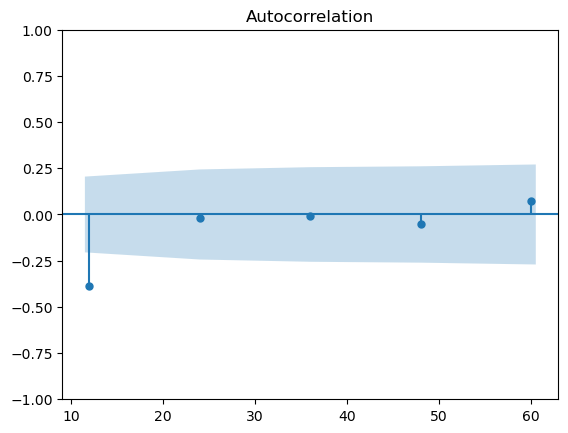

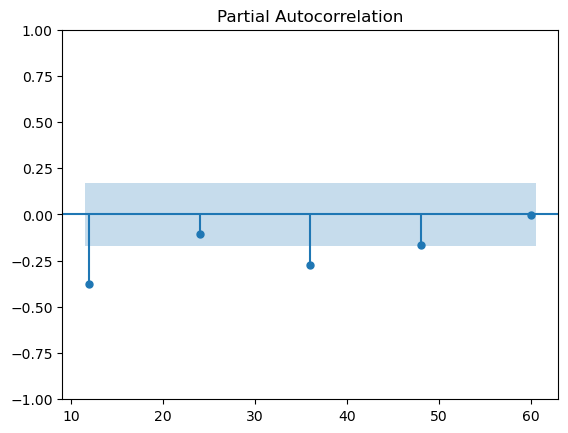

In [286]:
plot_acf(y_log_diff_season,lags=[12,24,36,48,60])
plot_pacf(y_log_diff_season,lags=[12,24,36,48,60])
plt.show()

Looks like an (0,1,0,)(0,1,1)12 model

In [296]:
order_aic_bic=[]
for p in range(3):
    for q in range(3):
        for P in range(4):
            for Q in range(4):
    
                try:
                    model = SARIMAX(y_log, order=(p,1,q), seasonal_order=(P,1,Q,12))
                    results = model.fit(disp=False)
                    order_aic_bic=[p,q,P,Q,results.aic,results.bic]
                except:
                    order_aic_bic=[p,q,P,Q,None,None]
order_aic_bic

[2, 2, 3, 3, -472.8016604330886, -441.17448987787594]

In [398]:
#QUESTION FOR MENTOR - WHY ONLY 1 OUTPUT?

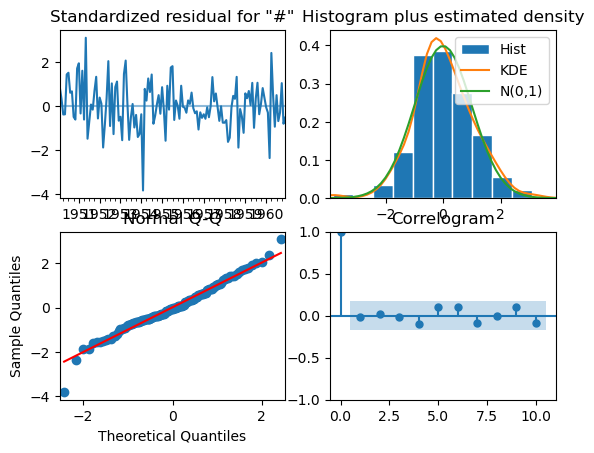

In [297]:
model = SARIMAX(y_log, order=(2,1,2), seasonal_order=(3,1,3,12))
results= model.fit(disp=False)
results.plot_diagnostics()
plt.show()

These look great. 
1. no discernable trend 
2. follows a normal distribution
3. follows Q-Q plot line
4. no residual correlations

### 3e. Visualize the results 

Visualize the original dataset plotted against our model. 

#### Overlaying the existing data with predict

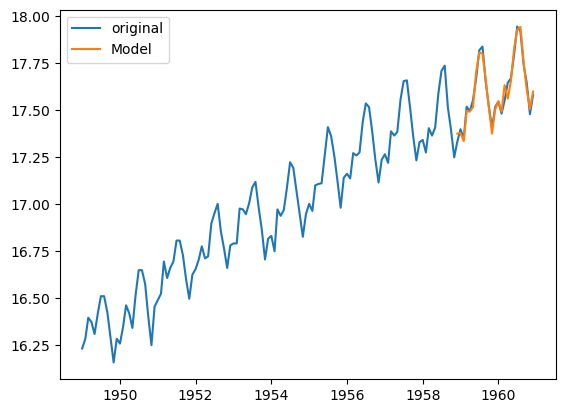

In [375]:
model_predict=results.get_prediction(start=-25)
model_mean=model_predict.predicted_mean
model_df =pd.DataFrame(model_mean).rename_axis('Month').reset_index()
plt.plot(y_log.index,y_log, label='original')
plt.plot(model_df.Month,model_df.predicted_mean, label='Model')
plt.legend()
plt.show()

#### forecast future data with forecast

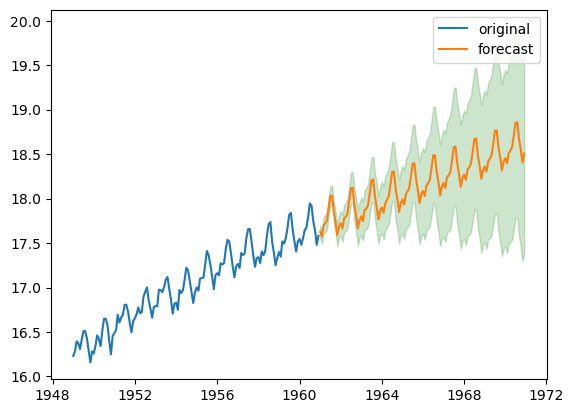

In [399]:
model_fore = results.get_forecast(steps=120)
model_mean = model_fore.predicted_mean
model_conf = model_fore.conf_int()
X = model_mean.index
plt.plot(y_log.index,y_log, label='original')
plt.plot(X,model_mean, label='forecast')
plt.fill_between(X,model_conf.iloc[:,0],model_conf.iloc[:,1],color='green',alpha=0.2)
plt.legend()
plt.show()

#### Reversing the log of our data

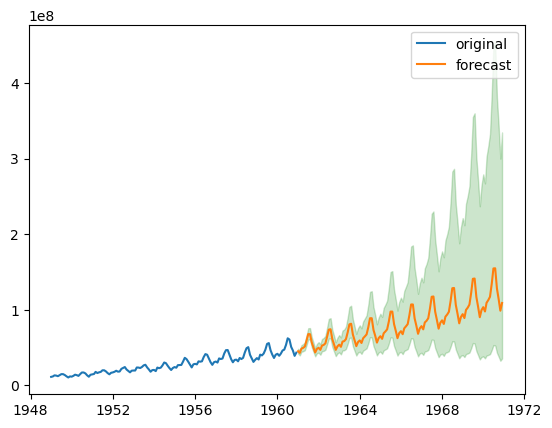

In [395]:
model_fore = results.get_forecast(steps=120)
model_mean = model_fore.predicted_mean
model_conf = model_fore.conf_int()
X = model_mean.index
plt.plot(y_log.index,np.exp(y_log), label='original')
plt.plot(X,np.exp(model_mean), label='forecast')
plt.fill_between(X,np.exp(model_conf).iloc[:,0],np.exp(model_conf).iloc[:,1],color='green',alpha=0.2)
plt.legend()
plt.show()

## 4. Evaluating and Concluding

Our model captures the centre of a line that's increasing at a remarkable rate. Cowboy Cigarettes sell more cigarettes in the summer, perhaps due to the good weather, disposable income and time off that people enjoy, and the least in the winter, when people might be spending less and enjoying less free time outdoors. 

Remarkably, our ARIMA model made predictions using just one variable. We can only speculate, however, on the causes of the behaviour predicted by our model. We should also take heed that spikes in data, due to sudden unusual circumstances like wars, are not handled well by ARIMA; and the outbreak of the Vietnam War in the 1960s would likely cause our model some distress.  

We could suggest to our employers that, if they are interested in discovering the causes of the cigarette sales trajectory, they execute a regression analysis in addition to the time series one. 

In [415]:
#max of data
cigData.max()

#CigSales    62200000
dtype: int64

In [407]:
#max of forecast
np.exp(model_mean).max()

154805035.9729292

From this model we can forecast that in 10 years time, the amount of cigarettes sold will jump from 62,200,000 to 154,805,036. That's a big increase!